# Decision Trees Project

This project implements **decision tree algorithms from scratch** for both regression and classification tasks. The project demonstrates tree construction using variance reduction as the splitting criterion, analyzes the suboptimality of greedy algorithms, and applies decision trees to real-world problems including bike sharing demand prediction and MNIST digit classification.

## Problem Statement

Decision trees are interpretable machine learning models that make predictions by recursively splitting data based on feature values. Unlike linear models, decision trees can capture non-linear relationships and feature interactions automatically through their hierarchical structure.

**Solution Approach**: 
- Implement recursive tree construction using depth-first search (DFS)
- Use variance reduction as the splitting criterion for regression trees
- Handle continuous features with threshold-based splits
- Apply trees to both regression (continuous outputs) and classification (discrete outputs) problems
- Analyze how greedy splitting decisions can lead to suboptimal trees

## Project Overview

This project provides **complete from-scratch implementation** of decision trees with comprehensive analysis:

1. **Regression Tree Implementation**: Custom `TreeEstimator` class using variance reduction
2. **Greedy Algorithm Analysis**: Demonstration of suboptimality in greedy splitting decisions
3. **Real-World Applications**: Bike sharing demand prediction and MNIST digit classification

### 1. Regression Tree Implementation

**Regression Trees** predict continuous values by minimizing variance at each split:

- **Splitting Criterion**: Variance reduction - choose split that maximizes reduction in weighted variance
- **Variance Reduction**: $\text{VarReduction} = \text{Var}(parent) - \left(\frac{n_{left}}{n} \cdot \text{Var}(left) + \frac{n_{right}}{n} \cdot \text{Var}(right)\right)$
- **Leaf Prediction**: Mean of target values in the leaf: $\hat{y} = \frac{1}{|L|} \sum_{i \in L} y_i$ where $L$ is the set of samples in the leaf
- **Tree Construction**: Recursive depth-first search (DFS) approach building tree from root to leaves

**Mathematical Foundation**:
- Parent variance: $\text{Var}(y) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \bar{y})^2$
- Weighted child variance: $\text{WeightedVar} = \frac{n_{left}}{n} \cdot \text{Var}(y_{left}) + \frac{n_{right}}{n} \cdot \text{Var}(y_{right})$
- Best split maximizes variance reduction, creating more homogeneous child nodes

### 2. Greedy Algorithm Suboptimality

**Greedy Splitting** makes locally optimal decisions at each node without considering global tree structure. Locally optimal splits may not lead to globally optimal tree, but the greedy approach is computationally efficient compared to exhaustive search.

## Decision Tree Implementation from Scratch

This section implements a basic `DecisionTree` class for regression that handles continuous input and output values. This implementation also works for binary input attributes.

In [1]:
import io
import requests
from typing import Tuple, List
import zipfile

import numpy as np
import pandas as pd

def read_csv_from_zip(url: str, specific_file: str) -> pd.DataFrame:
   """
   Reads a specific CSV file from a zip archive located at a given URL.

   Args:
       url (str): The URL of the zip file
       specific_file (str): The name of the specific CSV file inside the zip

   Returns:
       pd.DataFrame: DataFrame containing the data from the CSV file

   Raises:
       requests.exceptions.RequestException: If there is an error downloading the file
       FileNotFoundError: If the specified file is not found in the zip archive
   """
   # Download the zip file
   response = requests.get(url)
   response.raise_for_status()  # Check if the request was successful

   # Open the zip file in memory
   with zipfile.ZipFile(io.BytesIO(response.content)) as z:
       # Check if the specific file exists in the zip
       if specific_file not in z.namelist():
           raise FileNotFoundError(
               f"{specific_file} not found in the zip archive. "
               f"Available files: {z.namelist()}"
           )

       # Open the specific file and read it with pandas
       with z.open(specific_file) as f:
           return pd.read_csv(f)

def load_bike_sharing_data(dataset: str = 'day') -> Tuple[np.ndarray, np.ndarray, List[str]]:
   """
   Loads the Bike Sharing dataset and preprocesses it for regression.

   Args:
       dataset (str): Either 'day' or 'hour' to specify which data granularity to load

   Returns:
       Tuple containing:
           np.ndarray: Feature matrix X
           np.ndarray: Target vector y (total rentals)
           List[str]: List of feature names

   Notes:
       - Sets 'instant' as index
       - Removes date, year, and separated rental counts
       - Target variable 'cnt' represents total rentals
   """
   # Load data from UCI ML Repository
   url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
   specific_file = f"{dataset}.csv"

   # Read and preprocess the data
   df = read_csv_from_zip(url, specific_file)
   df = df.set_index('instant')  # Set ID column as index

   # Extract target variable (total rentals)
   y = df['cnt'].values

   # Remove unnecessary columns:
   # - dteday: redundant date information
   # - casual, registered: total count is used only
   # - cnt: this is our target variable
   df = df.drop(['dteday', 'casual', 'registered', 'cnt'], axis=1)

   # Convert features to numpy array and get feature names
   X = df.values
   attribute_names = list(df.columns)

   return X, y, attribute_names

# Load the daily bike sharing data
X, y, attribute_names = load_bike_sharing_data("day")

In [ ]:
from typing import Callable, Optional
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, RegressorMixin


class TreeNode:
    """TreeNode class"""
    
    def __init__(self,
                 depth: int,
                 decision: Optional[Callable[[np.ndarray], bool]]=None,
                 label: Optional[int]=None):
        """
        Args:
            decision Optional[Callable[[np.ndarray], bool]] decision function of the node, None by default
            label Optional[int] label for the leaf
            depth int depth of the node in the tree
        """
        self.decision = decision
        self.left = None
        self.right = None
        self.label = label
        self.depth = depth


class TreeEstimator(BaseEstimator, RegressorMixin):
    """Tree Regressor with variance reduction optimization"""
    
    def __init__(self, min_leaf: int=5, max_depth: int=None, verbose: bool=False):
        """
        Args:
            min_leaf int min number of samples a leaf may contain, 5 by default
            max_depth int maximum depth of the tree, None by default (no limit)
            verbose bool log verbosity
        """
        self.root: Optional[TreeNode] = None
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.verbose = verbose
        self.depth = 0

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'TreeEstimator':
        """
        Fit the model
        Args:
            X np.ndarray of shape (n,m) samples
            y np.ndarray of shape (n,) labels
        Returns:
            TreeEstimator fitted estimator
        """
        self.root = self._dfs(X, y, 0)
        return self

    def _dfs(self, X: np.ndarray, y: np.ndarray, depth: int) -> TreeNode:
        """
        Tree builder based on DFS
        Args:
            X np.ndarray of shape (n,m) samples
            y np.ndarray of shape (n,) labels
            depth int depth of the node in the tree
        Returns:
            TreeNode a built tree node
        """
        self.depth = max(self.depth, depth)
        n_samples, n_features = X.shape
        
        # Check max_depth
        if self.max_depth is not None and depth >= self.max_depth:
            unique_labels, counts = np.unique(y, return_counts=True)
            label = unique_labels[np.argmax(counts)]
            return TreeNode(label=label, depth=depth)
        
        if n_samples <= self.min_leaf:
            if self.verbose:
                print(f"Reached {n_samples} features, stopping")
            unique_labels, counts = np.unique(y, return_counts=True)
            label = unique_labels[np.argmax(counts)]
            return TreeNode(label=label, depth=depth)
        parent_var = np.var(y)
        best_split = None
        best_var_reduct = -np.inf
        for feat_idx in range(n_features):
            thresholds = np.unique(X[:, feat_idx])
            if len(thresholds) <= 1:
                continue  # Skip features with no variation
            for threshold in thresholds:
                left_indices = X[:, feat_idx] <= threshold
                right_indices = X[:, feat_idx] > threshold
                n_left, n_right = np.sum(left_indices), np.sum(right_indices)
                if n_left * n_right == 0:
                    if self.verbose:
                        print("Can't use threshold")
                    continue
                left_var, right_var = np.var(y[left_indices]), np.var(y[right_indices])
                weighted_var = (n_left * left_var + n_right * right_var) / n_samples
                var_reduct = parent_var - weighted_var
                if var_reduct > best_var_reduct:
                    best_var_reduct = var_reduct
                    best_split = (threshold, feat_idx)
        if best_split is None:
            unique_labels, counts = np.unique(y, return_counts=True)
            label = unique_labels[np.argmax(counts)]
            return TreeNode(label=label, depth=depth)

        threshold, feat_idx = best_split
        left_ind = X[:, feat_idx] <= threshold
        right_ind = X[:, feat_idx] > threshold
        node = TreeNode(decision=lambda x: x[feat_idx] <= threshold, depth=depth)
        node.left = self._dfs(X[left_ind], y[left_ind], depth + 1)
        node.right = self._dfs(X[right_ind], y[right_ind], depth + 1)
        return node

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict based on latest fit
        Args:
            X np.ndarray of shape (n', m) samples
        Returns:
            np.ndarray of shape (n',) samples
        Complexity:
            Omega(nm)
        """
        preds = np.zeros(X.shape[0], dtype=int)
        for idx, x in enumerate(X):
            curr_node = self.root
            while curr_node.label is None:
                if curr_node.decision(x):
                    curr_node = curr_node.left
                else:
                    curr_node = curr_node.right
            preds[idx] = curr_node.label
        return preds

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

tree = TreeEstimator()
tree.fit(X_train, y_train)
tree.score(X_train, y_train)

0.9513805012187448

In [4]:
tree.score(X_test, y_test)

0.7411356149810521

In [5]:
from tqdm import tqdm

best_l = None
best_depth = None
max_r2 = -np.inf
y_pred_optimal = None
train_scores, test_scores, depths = [], [], []
for min_l in tqdm(range(100)):
    dtmodel = TreeEstimator(min_leaf=min_l)
    dtmodel.fit(X_train, y_train)
    y_pred = dtmodel.predict(X_test)
    train_score = dtmodel.score(X_train, y_train)
    test_score = dtmodel.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    depths.append(dtmodel.depth)
    if test_score > max_r2:
        max_r2 = test_score
        best_l = min_l
        y_pred_optimal = y_pred
        best_depth = dtmodel.depth

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


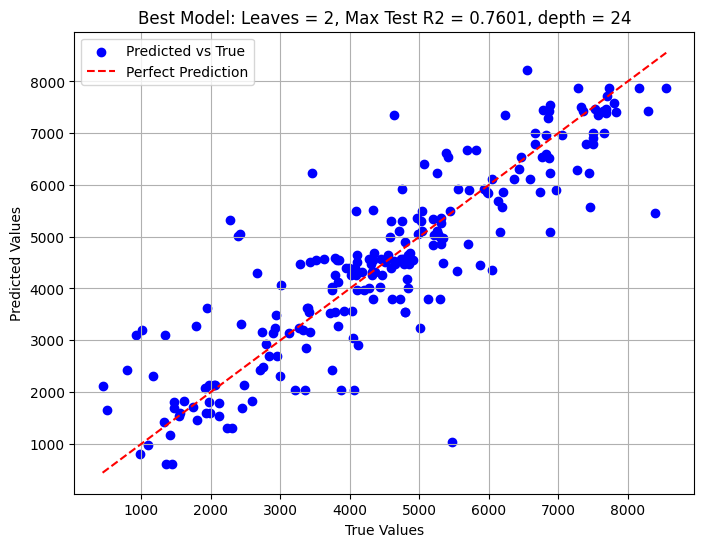

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_optimal, color='blue', label="Predicted vs True")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Prediction")
plt.title(f"Best Model: Leaves = {best_l}, Max Test R2 = {round(max_r2, 4)}, depth = {best_depth}")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()
plt.show()

**Let's take a look at how $R2$ score and tree depth depend on `min_leaf`.**

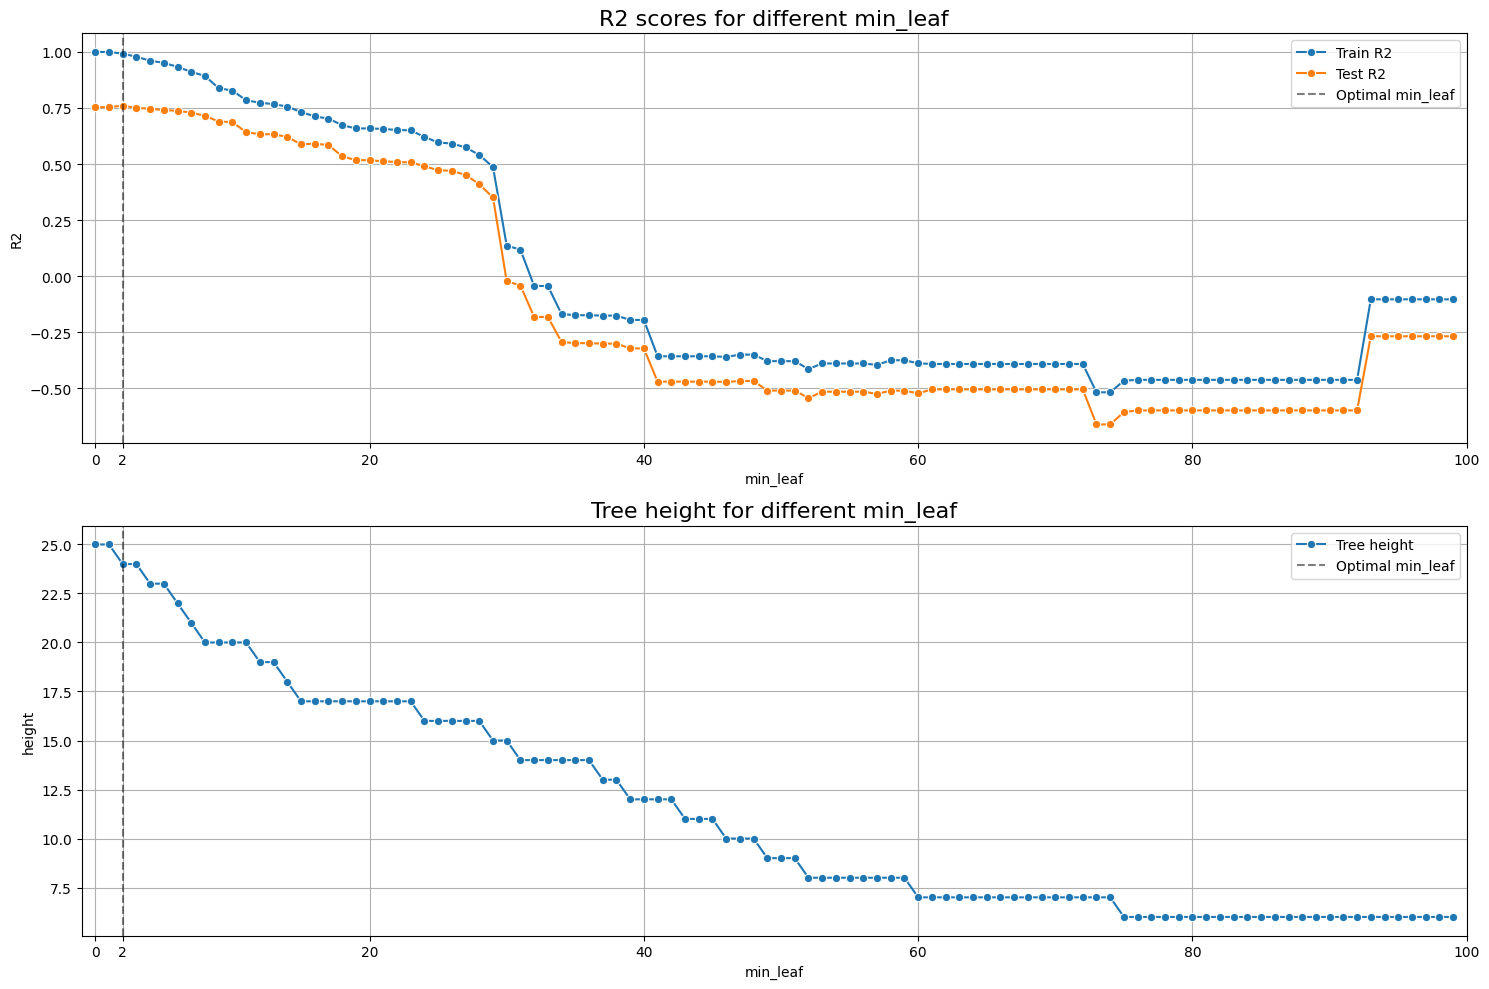

In [7]:
import seaborn as sns

fig, ax, = plt.subplots(2, 1, figsize=(15, 10))
sns.lineplot(x=range(100), y=train_scores, marker='o', label='Train R2', ax=ax[0])
sns.lineplot(x=range(100), y=test_scores, marker='o', label='Test R2', ax=ax[0])
ax[0].grid()
ax[0].set_xlabel("min_leaf")
ax[0].set_ylabel("R2")
ax[0].set_title("R2 scores for different min_leaf", fontsize=16)
ax[0].axvline(x=best_l, linestyle='--', color='k', alpha=0.5, label='Optimal min_leaf')
xticks = list(ax[0].get_xticks())
xticks.append(best_l)
ax[0].set_xticks(xticks)
ax[0].set_xlim(-1, 100)
ax[0].legend()
sns.lineplot(x=range(100), y=depths, marker='o', label='Tree height', ax=ax[1])
ax[1].grid()
ax[1].set_xlabel("min_leaf")
ax[1].set_ylabel("height")
ax[1].set_title("Tree height for different min_leaf", fontsize=16)
ax[1].axvline(x=best_l, linestyle='--', color='k', alpha=0.5, label='Optimal min_leaf')
xticks = list(ax[1].get_xticks())
xticks.append(best_l)
ax[1].set_xticks(xticks)
ax[1].set_xlim(-1, 100)
ax[1].legend()
plt.tight_layout()
plt.show();

## Using Decision Tree for MNIST Digit Classification

Tree models are simple and take on each feature separately, thus they don't require scaling. No preprocessing is performed, only the train test split.

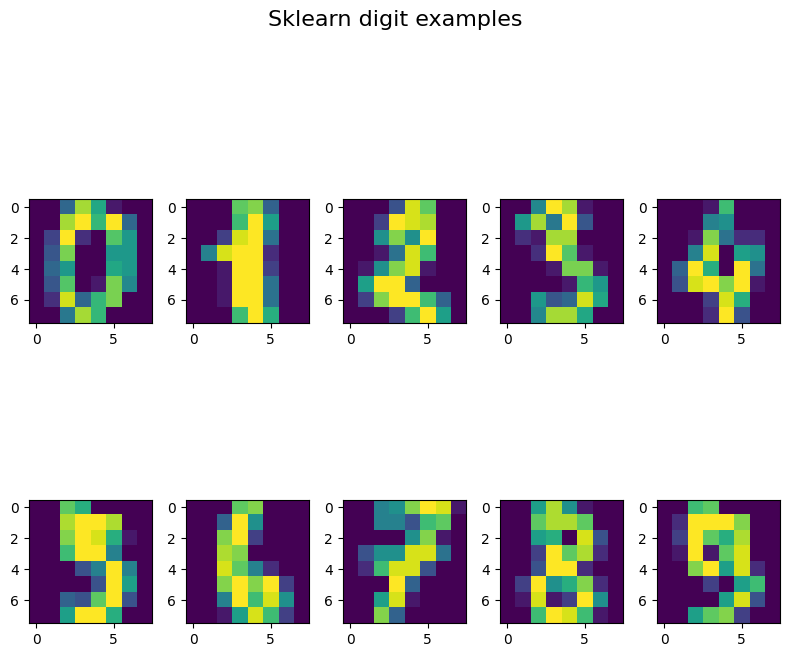

In [8]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

X, y = datasets.load_digits(return_X_y=True)

fig, ax = plt.subplots(2, 5, figsize=(8, 8))
for i in range(10):
    example = X[y==i][0]
    ax[i // 5][i % 5].imshow(np.asarray(example).reshape(8, 8))
fig.suptitle("Sklearn digit examples", fontsize=16)
plt.tight_layout()
plt.show();

These are low quality 8x8 images of digits. **Note that leftmost and rightmost columns are empty for virtually every image.**

Fitting 5 folds for each of 380 candidates, totalling 1900 fits


Best max_depth: 13
Best min_samples_split: 3
Best cross-validation accuracy: 0.8282
Test accuracy with best model: 0.8463


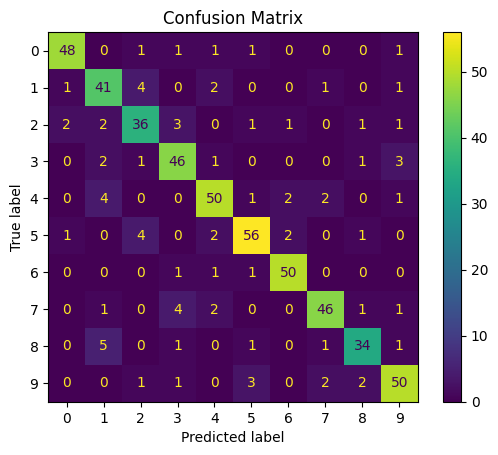

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
dtmodel = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': np.arange(1, 21),  # Testing depths from 1 to 20
    'min_samples_split': np.arange(2, 21)  # Testing min_samples_split from 2 to 20
}

grid_search = GridSearchCV(estimator=dtmodel, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f"Best max_depth: {grid_search.best_params_['max_depth']}")
print(f"Best min_samples_split: {grid_search.best_params_['min_samples_split']}")
print(f"Best cross-validation accuracy: {round(grid_search.best_score_, 4)}")

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
y_pred = best_model.predict(X_test)
print(f"Test accuracy with best model: {test_accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot()
plt.title("Confusion Matrix")
plt.show()


The test accuracy of 84% is reasonable. Most of the classes have never been confused, and the confused usually have up to 5 wrongly labelled samples for each confusion.

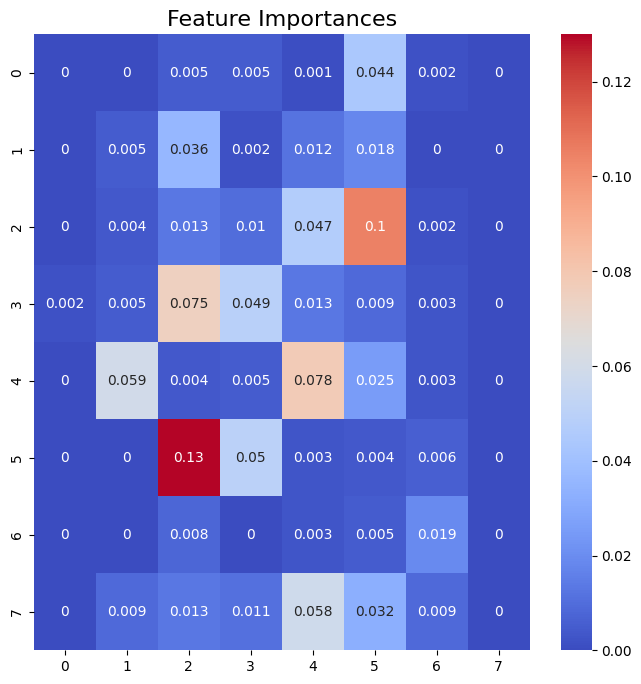

In [10]:
plt.figure(figsize=(8, 8))
feature_importances = best_model.feature_importances_.reshape(8, 8)
sns.heatmap(np.round(feature_importances, 3), cmap='coolwarm', annot=True)
plt.title("Feature Importances", fontsize=16)
plt.show()

As mentioned earlier, leftmost and rightmost columns are virtually almost empty, thus their importance is expectedly virtually zero. As anticipated, the tree model chose the features (i.e. pixels) with decisive importance, like e.g. one pixel with importance 0.13.

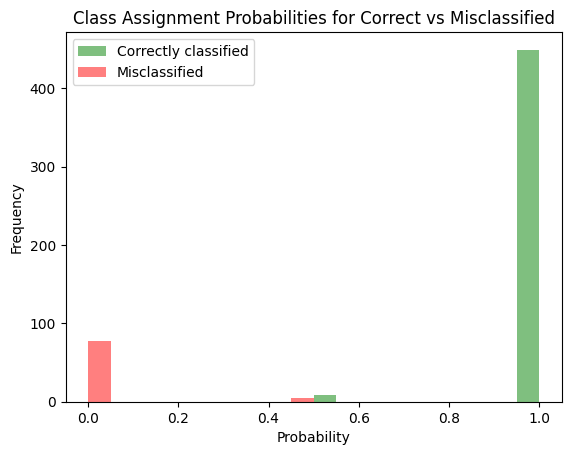

In [11]:
y_prob = best_model.predict_proba(X_test)
correct_probs = []
incorrect_probs = []
for i, (true, pred) in enumerate(zip(y_test, y_pred)):
    if true == pred:
        correct_probs.append(y_prob[i, true])
    else:
        incorrect_probs.append(y_prob[i, true])

plt.hist(correct_probs, bins=10, alpha=0.5, label='Correctly classified', color='g')
plt.hist(incorrect_probs, bins=10, alpha=0.5, label='Misclassified', color='r')
plt.title("Class Assignment Probabilities for Correct vs Misclassified")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()

**The most important pixels are the central pixels, which also achieved the best results in the confusion matrix. Best max_depth found is 13 with min_samples_split 3, which seems reasonable.**

Test accuracy achieved is 0.8463.